# The Olympics Database
* Explore the Olympics Dataset
* Creating Reports
* Cleaning & Validation
* Complex Calculations

## Importing Libraries

In [90]:
import psycopg2 as pg
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15

import warnings
warnings.filterwarnings('ignore')

## Connect to PostgreSQL

In [91]:
def create_db_connection(host_name, user_name, user_password, db_name):
    conn = None
    try:
        conn = pg.connect(
            host=host_name,
            user = user_name,
            password = user_password,
            database = db_name
        )
        print("PostgreSQL '{}' Database connection successful".format(db_name))
    except Exception as e:
        print(f"Error: '{e}'")
    return conn

In [92]:
conn = create_db_connection('localhost', 'postgres', 'password', 'sqlda3')
cur = conn.cursor()

PostgreSQL 'sqlda3' Database connection successful


# Dataset
![](images/olympics_erd.png)

In [93]:
q = """
select table_name, column_name, data_type
from information_schema.columns
where table_schema = 'public'
order by table_name
"""

schema_df = pd.read_sql(q, conn)
schema_df

,table_name,column_name,data_type
0,athletes,age,integer
1,athletes,id,integer
2,athletes,gender,character varying
3,athletes,name,character varying
4,athletes,weight,integer
5,athletes,height,integer
6,countries,region,character varying
7,countries,id,integer
8,countries,country,character varying
9,country_stats,gdp,double precision


# Top 3 sports with the most athletes

In [94]:
def barplot(dfx, dfy, c='tab:blue', orientation='vertical', fs=(12,8)):
    fig, ax = plt.subplots(figsize=fs)
    
    if orientation == 'vertical':
        sns.barplot(x=dfx, y=dfy, color=c)
        for i in range(len(dfx)):
            ax.annotate(str(dfy.iloc[i]), (i, dfy.iloc[i]))
    else:
        sns.barplot(x=dfy, y=dfx, color=c)
        for i in range(len(dfx)):
            ax.annotate(str(dfy.iloc[i]), (dfy.iloc[i], i))

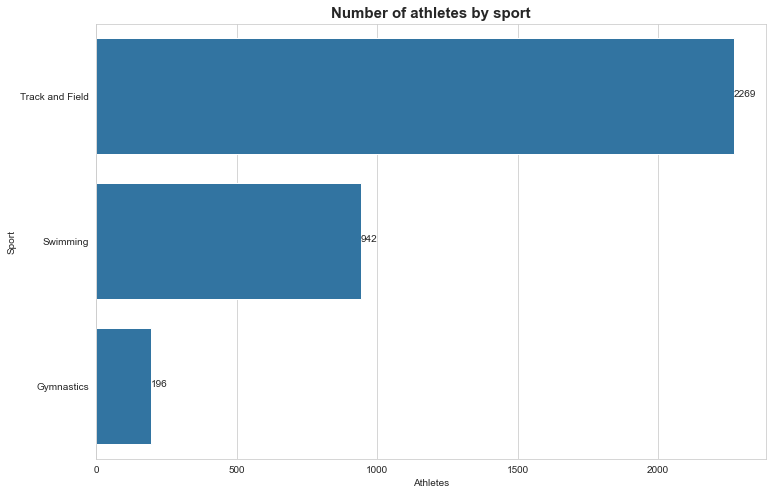

In [95]:
q = """
select sport, count(distinct(athlete_id)) as athletes
from summer_games
group by sport
order by athletes desc
limit 3;
"""

df = pd.read_sql(q,conn)

sns.set_style('whitegrid')
barplot(df.sport, df.athletes, orientation='horizontal')
plt.title('Number of athletes by sport')
plt.ylabel('Sport')
plt.xlabel('Athletes');


# Athletes vs events by sport

In [96]:
q = """
select sport, 
count(distinct(event)) as events, 
count(distinct(athlete_id)) as athletes
from summer_games
group by sport;
"""

pd.read_sql(q,conn)

,sport,events,athletes
0,Gymnastics,14,196
1,Swimming,34,942
2,Track and Field,47,2269


 # Age of oldest athlete by region

In [97]:
q = """
select region, max(age) as age_of_oldest_athlete
from athletes as a
join summer_games as s
on a.id = s.athlete_id
join countries as c
on s.country_id = c.id

group by region

order by age_of_oldest_athlete desc;
"""

pd.read_sql(q,conn)


,region,age_of_oldest_athlete
0,WESTERN EUROPE,46
1,ASIA (EX. NEAR EAST),44
2,LATIN AMER. & CARIB,42
3,C.W. OF IND. STATES,41
4,NORTHERN AMERICA,41
5,NORTHERN AFRICA,41
6,OCEANIA,40
7,NEAR EAST,40
8,EASTERN EUROPE,39
9,BALTICS,39


# Number of events in each sport

,sport,events
0,Track and Field,47
1,Swimming,34
2,Gymnastics,14
3,Cross Country Skiing,12
4,Alpine Skiing,10
5,Biathlon,10


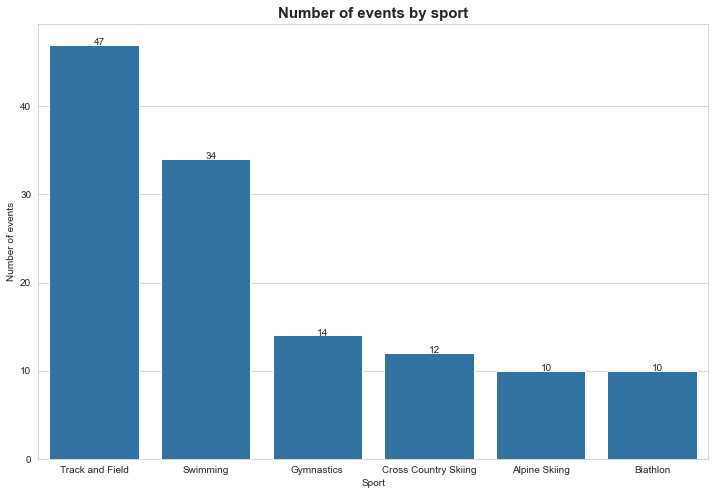

In [98]:
q = """
select sport, count(distinct(event)) as events
from summer_games
group by sport

union

select sport, count(distinct(event)) as events
from winter_games
group by sport

order by events desc
"""

df = pd.read_sql(q,conn)

barplot(df.sport, df.events)
plt.xlabel('Sport')
plt.ylabel('Number of events')
plt.title('Number of events by sport');


df


# Explore `summer_games` table


In [99]:
q = """
select bronze, count(*) as rows
from summer_games
group by bronze;
"""

pd.read_sql(q, conn)

,bronze,rows
0,NaN,4796
1,1.0,141


In [100]:
pd.read_sql('select * from summer_games', conn).isna().sum()

sport            0
event            0
year             0
athlete_id       0
country_id       0
bronze        4796
silver        4788
gold          4778
dtype: int64

# Bronze medals by country

In [101]:
q = """
select country, sum(coalesce(bronze,0)) as total_bronze

from summer_games as s
join countries as c
on s.country_id = c.id
group by country

order by total_bronze desc
"""

df = pd.read_sql(q, conn)
df


,country,total_bronze
0,CAN - Canada,21.0
1,U.S.A. - United States,20.0
2,CHN - China,15.0
3,G.BR - Great Britain,14.0
4,AUS - Australia,12.0
...,...,...
198,C.Af - Central African Republic,0.0
199,LBR - Liberia,0.0
200,qat. - qatar,0.0
201,SGP - Singapore,0.0


# Validate the join
* INNER JOIN() could lead to some data being left out
* validate the join by comparing total bronze medals

In [102]:
q = """
select sum(bronze) as total_bronze_medals
from summer_games;
"""

pd.read_sql(q, conn) == df.total_bronze.sum()

,total_bronze_medals
0,True


# Most decorated summer athletes

,athlete_name,gold_medals
0,"Michael Fred Phelps, II",5.0
1,"Kathleen Genevieve ""Katie"" Ledecky",4.0
2,Simone Arianne Biles,4.0
3,Katinka Hossz,3.0
4,Usain St. Leo Bolt,3.0
...,...,...
126,Pernille Blume,1.0
127,Brittany Joyce Elmslie,1.0
128,Sharon van Rouwendaal,1.0
129,"Nafissatou ""Nafi"" Thiam",1.0


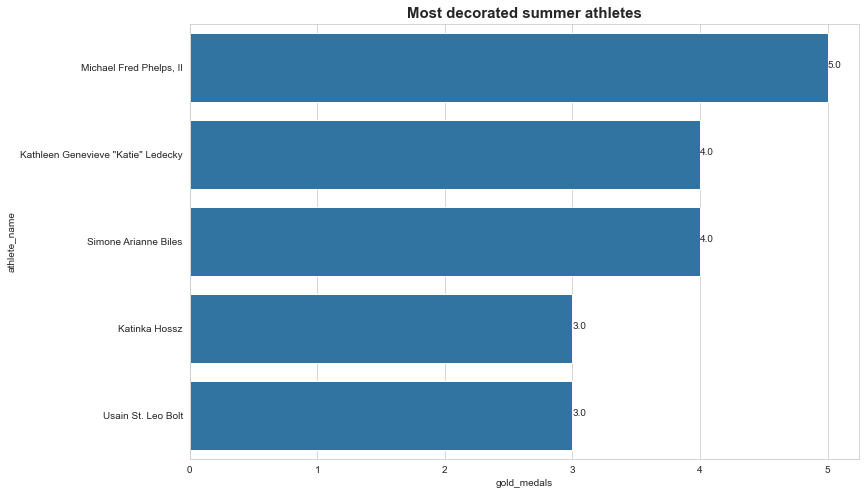

In [103]:
q = """
select name as athlete_name,
sum(gold) as gold_medals

from summer_games as s
join athletes as a
on s.athlete_id = a.id

group by a.name
having sum(gold) is not null
order by gold_medals desc
"""

df = pd.read_sql(q, conn)

barplot(df.loc[0:4].athlete_name, df.loc[0:4].gold_medals, orientation='horizontal') 
plt.title('Most decorated summer athletes')
df


# UNION then JOIN query
Goal is to a report, which contains the following fields:
* **season**, which outputs either summer or winter
* **country**
* **events**, which shows the unique number of events

In [104]:
# 1. UNION JOIN WINTER & SUMMER as subquery
q = """
select * from 

(select 'summer' as season,
country_id,
event
from summer_games

union all

select 'winter' as season,
country_id,
event
from winter_games) as subquery

"""

pd.read_sql(q,conn)

,season,country_id,event
0,summer,173,Gymnastics Men's Individual All-Around
1,summer,173,Gymnastics Men's Floor Exercise
2,summer,173,Gymnastics Men's Parallel Bars
3,summer,173,Gymnastics Men's Horizontal Bar
4,summer,173,Gymnastics Men's Rings
...,...,...,...
7046,winter,152,Alpine Skiing Men's Super G
7047,winter,152,Alpine Skiing Men's Giant Slalom
7048,winter,152,Alpine Skiing Men's Slalom
7049,winter,102,Alpine Skiing Men's Giant Slalom


In [105]:
# 2. join the subquery with country
q = """
select * from

(select 'summer' as season,
country_id,
event
from summer_games

union all

select 'winter' as season,
country_id,
event
from winter_games) as subquery

join countries as c
on subquery.country_id = c.id

"""

pd.read_sql(q,conn)

,season,country_id,event,id,country,region
0,summer,173,Gymnastics Men's Individual All-Around,173,ESP - Spain,WESTERN EUROPE
1,summer,173,Gymnastics Men's Floor Exercise,173,ESP - Spain,WESTERN EUROPE
2,summer,173,Gymnastics Men's Parallel Bars,173,ESP - Spain,WESTERN EUROPE
3,summer,173,Gymnastics Men's Horizontal Bar,173,ESP - Spain,WESTERN EUROPE
4,summer,173,Gymnastics Men's Rings,173,ESP - Spain,WESTERN EUROPE
...,...,...,...,...,...,...
7046,winter,152,Alpine Skiing Men's Super G,152,RUS - Russia,C.W. OF IND. STATES
7047,winter,152,Alpine Skiing Men's Giant Slalom,152,RUS - Russia,C.W. OF IND. STATES
7048,winter,152,Alpine Skiing Men's Slalom,152,RUS - Russia,C.W. OF IND. STATES
7049,winter,102,Alpine Skiing Men's Giant Slalom,102,LAT - Latvia,BALTICS


In [106]:
# 3. Aggregate
q = """
select season, 
country, 
count(distinct(event)) as events 
from

(select 'summer' as season,
country_id,
event
from summer_games

union all

select 'winter' as season,
country_id,
event
from winter_games) as subquery

join countries as c
on subquery.country_id = c.id

group by season, country

"""

pd.read_sql(q,conn)

,season,country,events
0,summer,ANT - Antigua and Barbuda,5
1,summer,CAM - Cambodia,4
2,summer,CAN - Canada,73
3,summer,cro - croatia,15
4,summer,COK - Cook Islands,4
...,...,...,...
276,winter,tur - Turkey,9
277,winter,U.S.A. - United States,32
278,winter,UKR - Ukraine,22
279,winter,UZB - Uzbekistan,4


# BMI bucket by sport
Understand how BMI differs by each summer sport. To answer this, set up a report that contains the following:

* **sport**, which is the name of the summer sport
* **bmi_bucket**, which splits up BMI into three groups: <.25, .25-.30, >.30
* **athletes**, or the unique number of athletes

Definition: BMI = 100 * weight / (height squared).

,sport,bmi_bucket,athletes
0,Gymnastics,.25-.30,4
1,Gymnastics,<.25,190
2,Gymnastics,>.30,1
3,Gymnastics,no weight recorded,1
4,Swimming,.25-.30,46
5,Swimming,<.25,864
6,Swimming,>.30,3
7,Swimming,no weight recorded,29
8,Track and Field,.25-.30,174
9,Track and Field,<.25,1886


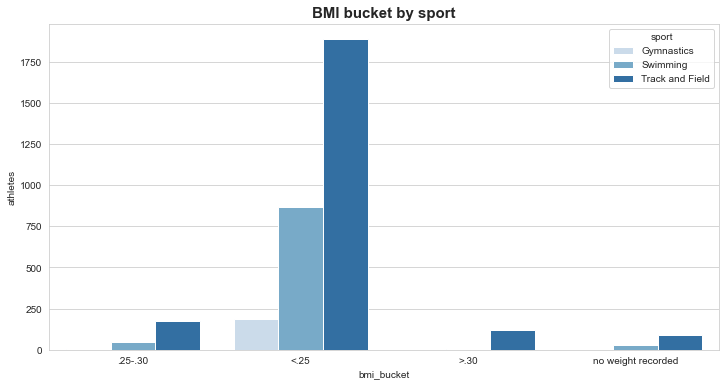

In [107]:
q = """
select sport, 

case when 100 * weight / (height^2) < .25 then '<.25'
when 100 * weight / (height^2) < .25 then '<.25'
when 100 * weight / (height^2) <= .3 then '.25-.30'
when 100 * weight / (height^2) > .30 then '>.30' 
else 'no weight recorded'
end as bmi_bucket,

count(distinct(name)) as athletes


from athletes as a
join summer_games as s
on a.id = s.athlete_id
group by sport, bmi_bucket

order by sport, bmi_bucket
"""



df = pd.read_sql(q, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=df, x='bmi_bucket', y='athletes', hue='sport', palette='Blues')

plt.title('BMI bucket by sport')
df

# Top athletes in nobel-prized countries
**Athletes Representing Nobel-Prize Winning Countries**

Report Details:

* Column 1 should be `event`, which represents the Olympic event. Both summer and winter events should be included.
* Column 2 should be `gender`, which represents the gender of athletes in the event.
* Column 3 should be `athletes`, which represents the unique athletes in the event.
* Athletes from countries that have had no `nobel_prize_winners` should be excluded.
* The report should contain 10 events, where events with the most `athletes` show at the top.

In [108]:
q = """
select * 
from country_stats
"""

pd.read_sql(q, conn)

,year,country_id,gdp,pop_in_millions,nobel_prize_winners
0,2000-01-01,1,NaN,20.093756,0
1,2000-01-01,2,3.632044e+09,3.089027,0
2,2000-01-01,3,5.479025e+10,31.18366,0
3,2000-01-01,4,NaN,0.057521,0
4,2000-01-01,5,1.434430e+09,0.06539,0
...,...,...,...,...,...
3446,2016-01-01,199,NaN,31.568179,0
3447,2016-01-01,200,2.050000e+11,94.569072,0
3448,2016-01-01,201,1.821333e+10,27.584213,0
3449,2016-01-01,202,2.095475e+10,16.59139,0


In [109]:
q = """
select event,

case when event like '%Women%' then 'female'
when event like '%Men%' then 'male'
else 'nah' 
end as gender,

count(distinct(athlete_id)) as athletes

from
(
    select event, country_id, athlete_id
    from summer_games

    union
    
    select event, country_id, athlete_id
    from winter_games
    ) as subquery
    
    where subquery.country_id in (
        select country_id 
        from country_stats 
        where nobel_prize_winners > 0)
        
    group by event
    order by athletes desc

    limit 10

"""


pd.read_sql(q, conn)

,event,gender,athletes
0,Swimming Women's 4 x 100 metres Medley Relay,female,56
1,Swimming Women's 4 x 100 metres Freestyle Relay,female,55
2,Swimming Women's 4 x 200 metres Freestyle Relay,female,52
3,Gymnastics Women's Team All-Around,female,50
4,Swimming Men's 4 x 200 metres Freestyle Relay,male,49
5,Swimming Men's 4 x 100 metres Medley Relay,male,45
6,Gymnastics Men's Team All-Around,male,45
7,Swimming Men's 4 x 100 metres Freestyle Relay,male,44
8,Gymnastics Women's Floor Exercise,female,43
9,Gymnastics Women's Uneven Bars,female,43


# Cleaning `country_stats` table

In [110]:
q = """
select column_name, data_type
from information_schema.columns
where table_name = 'country_stats';
"""

pd.read_sql(q,conn)


,column_name,data_type
0,country_id,integer
1,gdp,double precision
2,nobel_prize_winners,integer
3,year,character varying
4,pop_in_millions,character varying


In [111]:
pd.read_sql('select year, pop_in_millions from country_stats limit 5;', conn)

,year,pop_in_millions
0,2000-01-01,20.093756
1,2000-01-01,3.089027
2,2000-01-01,31.18366
3,2000-01-01,0.057521
4,2000-01-01,0.06539


* `years` and `pop_in_millions` are the wrong data type
* need to change them to numeric
* `years` can be changed to date

In [112]:
q = """
select avg(pop_in_millions::numeric) as avg_population
from country_stats;
"""
pd.read_sql(q,conn)


,avg_population
0,33.935339


# Using date functions on strings

In [113]:
q = """
select year, 
date_part('decade', year::date) as decade,
sum(gdp) as world_gdp

from country_stats
group by year
order by year desc;
"""

pd.read_sql(q,conn)


,year,decade,world_gdp
0,2016-01-01,201.0,7.433875e+13
1,2015-01-01,201.0,7.337495e+13
2,2014-01-01,201.0,7.795138e+13
3,2013-01-01,201.0,7.592508e+13
4,2012-01-01,201.0,7.390076e+13
5,2011-01-01,201.0,7.227351e+13
6,2010-01-01,201.0,6.511221e+13
7,2009-01-01,200.0,5.935604e+13
8,2008-01-01,200.0,6.256977e+13
9,2007-01-01,200.0,5.713112e+13


# Replacing and removing substrings
* Create the field `character_swap` that replaces all `'&'` characters with `'and'` from `region`.
* Create the field `character_remove` that removes all periods from `region`.

In [114]:
q = """
select region,
lower(region) as after_lower_case,
replace(region, '&', 'and') as after_character_swap,
replace(region, '.', '') as after_character_remove,

lower(replace(replace(replace(region, '&', 'and'), '.', ''), ' ', '_')) as consistent_col_name


from (
    select distinct(region)
    from countries
    where region like '%&%' or region like '%.%'
    ) as subquery

"""

pd.read_sql(q,conn)

,region,after_lower_case,after_character_swap,after_character_remove,consistent_col_name
0,ASIA (EX. NEAR EAST),asia (ex. near east),ASIA (EX. NEAR EAST),ASIA (EX NEAR EAST),asia_(ex_near_east)
1,LATIN AMER. & CARIB,latin amer. & carib,LATIN AMER. and CARIB,LATIN AMER & CARIB,latin_amer_and_carib
2,C.W. OF IND. STATES,c.w. of ind. states,C.W. OF IND. STATES,CW OF IND STATES,cw_of_ind_states


# Fixing calculations with coalesce on Null values
* Null values impact aggregations in a number of ways. 
* One issue is related to the `AVG()` function. 
* By default, the `AVG()` function does not take into account any null values. 
* However, there may be times when you want to include these null values in the calculation as zeros.

In [115]:
q = """
select athlete_id, name, total_events, gold_medals, avg_gold_medals

from (
    select athlete_id,
    count(event) as total_events,
    sum(coalesce(gold,0)) as gold_medals,
    avg(coalesce(gold,0)) as avg_gold_medals

    from summer_games

    group by athlete_id
    order by total_events desc, athlete_id
    ) as s
    
    join athletes as a
    on s.athlete_id = a.id;
"""

pd.read_sql(q,conn)

,athlete_id,name,total_events,gold_medals,avg_gold_medals
0,51,Nstor Abad Sanjun,6,0.0,0.0
1,55,Antonio Abadia Beci,1,0.0,0.0
2,110,Abubakar Abbas Abbas,1,0.0,0.0
3,251,Bashir Abdi,2,0.0,0.0
4,273,Maizurah Abdul Rahim,1,0.0,0.0
...,...,...,...,...,...
3403,135410,Zaidatul Husniah Zulkifli,1,0.0,0.0
3404,135431,Stipe uni,1,0.0,0.0
3405,135477,Vaida sinait,1,0.0,0.0
3406,135489,Anastasiya Valeryevna Zuyeva-Fesikova,3,0.0,0.0


# Identifying duplication
* Check for duplication in `gold_medals`

In [116]:
q = """
select sum(gold) as gold_medals
from winter_games
"""

pd.read_sql(q, conn)

,gold_medals
0,47.0


In [117]:
q = """
select sum(gold) as gold_medals
from winter_games as w
join country_stats as c
on w.country_id = c.country_id
"""

pd.read_sql(q,conn)

,gold_medals
0,799.0


In [118]:
q = """
select sum(gold) as gold_medals

from winter_games as w
join country_stats as c
on w.country_id = c.country_id and w.year = c.year::date

"""
pd.read_sql(q,conn)

,gold_medals
0,47.0


Since `gold_medals` duplication was caused by the extra rows in the `year` field, adding this to the ON statement solved the duplication.

# Countries with high medal rates
Details for **report: medals vs population rate.**

* Column 1 should be `country_code`, which is an altered version of the `country` field.
* Column 2 should be `pop_in_millions`, representing the population of the country (in millions).
* Column 3 should be `medals`, representing the total number of medals.
* Column 4 should be `medals_per_million`, which equals `medals` / `pop_in_millions`

,country_code,pop_in_millions,medals,medals_per_million
0,BAH - Bahamas,0.391232,6.0,15.336169
1,Jam - Jamaica,2.881355,30.0,10.411768
2,grn - grenada,0.107317,1.0,9.318188
3,NOR - Norway,5.137232,23.0,4.477119
4,swe - sweden,9.69611,19.0,1.959549
5,SLO - Slovenia,2.06198,4.0,1.939883
6,AUT - Austria,8.546356,14.0,1.638125
7,FIN - Finland,5.461512,8.0,1.464796
8,AUS - Australia,24.210809,34.0,1.404331
9,brn - bahrain,1.425171,2.0,1.403340


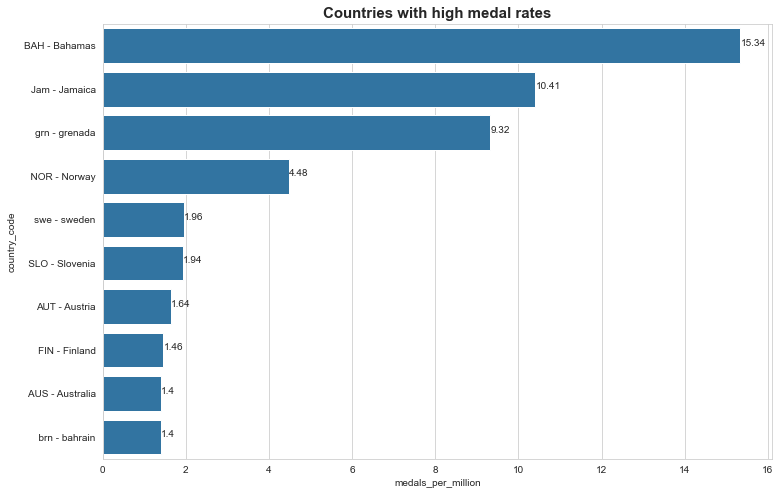

In [119]:
q = """
select country as country_code,
pop_in_millions,
sum(coalesce(bronze,0) + coalesce(silver,0) + coalesce(gold,0)) as medals,
sum(coalesce(bronze,0) + coalesce(silver,0) + coalesce(gold,0)) / pop_in_millions::numeric as medals_per_million

from (
    select * 
    from countries as c
    join summer_games as s
    on c.id = s.country_id
    
    union
    
    select * 
    from countries as c
    join winter_games as w
    on c.id = w.country_id
    ) as subquery

join country_stats as cs
on subquery.country_id = cs.country_id and subquery.year = cs.year::date

where pop_in_millions is not null
group by country, pop_in_millions
order by medals_per_million desc
limit 10
"""


df = pd.read_sql(q,conn)

barplot(df.country_code, round(df.medals_per_million,2), orientation='horizontal');
plt.title('Countries with high medal rates')
df


# Most decorated athlete per region

In [120]:
q = """
select * 
from (
    select 
        region, 
        name, 
        sum(gold) as total_gold,
        sum(gold) over(partition by region) as region_gold,
        row_number() over(partition by region order by sum(gold) desc) as region_rank

    from summer_games as s
    join athletes as a
    on s.athlete_id = a.id
    join countries as c
    on s.country_id = c.id

    group by region, name, gold
    having sum(gold) is not null

    order by region_rank
    ) as subquery;
"""

pd.read_sql(q,conn)

,region,name,total_gold,region_gold,region_rank
0,NEAR EAST,Ruth Jebet,1.0,1.0,1
1,C.W. OF IND. STATES,Dmitry Igorevich Balandin,1.0,4.0,1
2,EASTERN EUROPE,Katinka Hossz,3.0,5.0,1
3,LATIN AMER. & CARIB,Usain St. Leo Bolt,3.0,11.0,1
4,ASIA (EX. NEAR EAST),Kohei Uchimura,2.0,12.0,1
...,...,...,...,...,...
126,NORTHERN AMERICA,Abbey Weitzeil,1.0,65.0,61
127,NORTHERN AMERICA,Ryan Steven Lochte,1.0,65.0,62
128,NORTHERN AMERICA,"Lauren Zoe ""Laurie"" Hernandez",1.0,65.0,63
129,NORTHERN AMERICA,Leah Smith,1.0,65.0,64


# Percent of gdp per country

In [121]:
q = """
select
    region,
    country,
    sum(gdp) as country_gdp,
    sum(sum(gdp)) over() as global_gdp,
    sum(gdp)/sum(sum(gdp)) over() as perc_global_gdp,
    sum(gdp)/sum(sum(gdp)) over(partition by region) as perc_region_gdp
from 
    country_stats as cs
    join countries as c
    on cs.country_id = c.id
    where gdp is not null

group by region, country

order by country_gdp desc
"""

pd.read_sql(q,conn)

,region,country,country_gdp,global_gdp,perc_global_gdp,perc_region_gdp
0,NORTHERN AMERICA,U.S.A. - United States,2.438000e+14,9.715322e+14,2.509438e-01,0.913628
1,ASIA (EX. NEAR EAST),CHN - China,9.058000e+13,9.715322e+14,9.323417e-02,0.354972
2,ASIA (EX. NEAR EAST),JPN - Japan,8.407000e+13,9.715322e+14,8.653341e-02,0.329460
3,WESTERN EUROPE,ger - Germany,5.300000e+13,9.715322e+14,5.455300e-02,0.206902
4,WESTERN EUROPE,G.BR - Great Britain,4.205000e+13,9.715322e+14,4.328215e-02,0.164155
...,...,...,...,...,...,...
191,LATIN AMER. & CARIB,CAY - Cayman Islands,3.207033e+09,9.715322e+14,3.301005e-06,0.000046
192,SUB-SAHARAN AFRICA,S.T.P. - Sao Tome and Principe,3.135309e+09,9.715322e+14,3.227179e-06,0.000177
193,OCEANIA,MHL - Marshall Islands,2.618646e+09,9.715322e+14,2.695378e-06,0.000139
194,OCEANIA,KIR - Kiribati,2.251355e+09,9.715322e+14,2.317324e-06,0.000120


# GDP per capita performance index in 2016
1. Create a window function that outputs the performance for the entire partition.
2. Run a ratio that divides each row's performance to the performance of the entire partition.

* `gdp_per_million = gdp / pop_in_millions`

In [122]:
q = """
select 
    region,
    country,
    sum(gdp) / sum(pop_in_millions::numeric) as gdp_per_million,
    sum(sum(gdp)) over() as total_gdp,
    sum(sum(pop_in_millions::numeric)) over() total_pop_in_millions,
    sum(sum(gdp)) over() / sum(sum(pop_in_millions::numeric)) over() as total_gdp_per_million

from 
    country_stats as cs
    join countries as c
    on cs.country_id = c.id
    where gdp is not null and year = '2016-01-01'

group by region, country
order by gdp_per_million desc;
"""

df = pd.read_sql(q,conn)
df

,region,country,gdp_per_million,total_gdp,total_pop_in_millions,total_gdp_per_million
0,WESTERN EUROPE,LUX - Luxembourg,1.007387e+11,7.433875e+13,7279.639857,1.021187e+10
1,WESTERN EUROPE,SUI - Switzerland,7.989645e+10,7.433875e+13,7279.639857,1.021187e+10
2,WESTERN EUROPE,NOR - Norway,7.087566e+10,7.433875e+13,7279.639857,1.021187e+10
3,WESTERN EUROPE,IRL - Ireland,6.413849e+10,7.433875e+13,7279.639857,1.021187e+10
4,WESTERN EUROPE,ISL - Iceland,6.052993e+10,7.433875e+13,7279.639857,1.021187e+10
...,...,...,...,...,...,...
181,SUB-SAHARAN AFRICA,moz- Mozambique,3.820695e+08,7.433875e+13,7279.639857,1.021187e+10
182,SUB-SAHARAN AFRICA,NIG - Niger,3.679560e+08,7.433875e+13,7279.639857,1.021187e+10
183,SUB-SAHARAN AFRICA,MAW - Malawi,3.003077e+08,7.433875e+13,7279.639857,1.021187e+10
184,SUB-SAHARAN AFRICA,BDI - Burundi,2.857274e+08,7.433875e+13,7279.639857,1.021187e+10


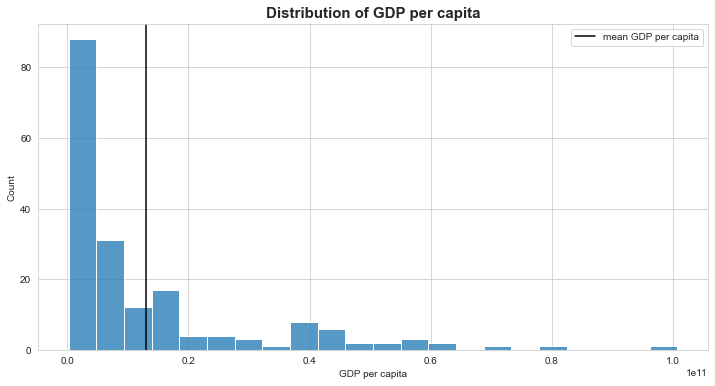

In [123]:
plt.figure(figsize=(12,6))

sns.histplot(df.gdp_per_million)
plt.axvline(df.gdp_per_million.mean(), color='k', label='mean GDP per capita')
plt.title('Distribution of GDP per capita')
plt.legend()
plt.xlabel('GDP per capita');

# Average of tallest athletes and % of world GDP by region
The final report on the dashboard is **Avg Tallest Athlete and % of world GDP by Region.**

Report Details:

* Column 1 should be `region` found in the `countries` table.
* Column 2 should be `avg_tallest`, which averages the tallest athlete from each country within the region.
* Column 3 should be `perc_world_gdp`, which represents what % of the world's GDP is attributed to the region.
* Only `winter_games` should be included (no summer events).

In [124]:
# pull country id, height, athlete_id, and rank their height 
q = """
select 
    athlete_id,
    country_id, 
    height,
    row_number() over (partition by country_id order by height desc) as row_num

from summer_games as s
join athletes as a
on s.athlete_id = a.id


"""
pd.read_sql(q, conn)

,athlete_id,country_id,height,row_num
0,133698,1,175,1
1,133277,1,165,2
2,112041,2,195,1
3,50381,2,193,2
4,78895,2,180,3
...,...,...,...,...
4933,56465,203,172,5
4934,83805,203,170,6
4935,87477,203,163,7
4936,84923,203,158,8


In [125]:
# Avg tallest athlete per region
q = """
select 
    region,
    avg(height) as avg_tallest

from countries as c
join
    (select 
        country_id, 
        height,
        row_number() over (partition by country_id order by height desc) as ranking

    from summer_games as s
    join athletes as a
    on s.athlete_id = a.id

    order by country_id, height desc
    ) as subquery

on c.id = subquery.country_id
where ranking = 1
group by region;

"""
pd.read_sql(q, conn)

,region,avg_tallest
0,ASIA (EX. NEAR EAST),179.692308
1,BALTICS,196.666667
2,C.W. OF IND. STATES,193.250000
3,EASTERN EUROPE,195.133333
4,LATIN AMER. & CARIB,187.026316
5,NEAR EAST,189.083333
6,NORTHERN AFRICA,185.200000
7,NORTHERN AMERICA,198.333333
8,OCEANIA,182.466667
9,SUB-SAHARAN AFRICA,180.183673


In [126]:
# Avg tallest athlete per region + % of world GDP
q = """
select 
    region,
    avg(height) as avg_tallest,
    sum(gdp) as region_gdp,
    sum(sum(gdp)) over() as world_gdp,
    sum(gdp) / sum(sum(gdp)) over() as perc_world_gdp


from countries as c
join
    (select 
        country_id, 
        height,
        row_number() over (partition by country_id order by height desc) as ranking

    from summer_games as s
    join athletes as a
    on s.athlete_id = a.id

    order by country_id, height desc
    ) as subquery

on c.id = subquery.country_id
join country_stats as cs
on subquery.country_id = cs.country_id

where ranking = 1
group by region
having region is not null

order by avg_tallest desc;

"""
pd.read_sql(q, conn)

,region,avg_tallest,region_gdp,world_gdp,perc_world_gdp
0,NORTHERN AMERICA,198.333333,2.668483e+14,9.715322e+14,0.274667
1,BALTICS,196.666667,1.243953e+12,9.715322e+14,0.001280
2,WESTERN EUROPE,196.000000,2.561597e+14,9.715322e+14,0.263666
3,EASTERN EUROPE,195.133333,1.895771e+13,9.715322e+14,0.019513
4,C.W. OF IND. STATES,193.250000,2.725233e+13,9.715322e+14,0.028051
5,NEAR EAST,189.083333,3.113496e+13,9.715322e+14,0.032047
6,LATIN AMER. & CARIB,187.026316,7.003926e+13,9.715322e+14,0.072092
7,NORTHERN AFRICA,185.200000,8.229325e+12,9.715322e+14,0.008470
8,OCEANIA,182.466667,1.880115e+13,9.715322e+14,0.019352
9,SUB-SAHARAN AFRICA,180.183673,1.769026e+13,9.715322e+14,0.018209


In [127]:
conn.close()